### XGBoost + ADSTuner
* added feature engineering
* added year, removed temp
* removing day I got the best results. (The range of days in the train set don't match with test set)


In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

# to encode categoricals
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

# see utils.py
from utils import add_features, rmsle, train_encoders, apply_encoders
from utils import show_tuner_results, show_categoricals

# set seaborn look&feel
sns.set()

In [2]:
# globals and load train dataset

STUDY_NAME = "Bike sharing11"

# number of folds for K-fold cv in ADSTuner
FOLDS = 7

# in secs
TIME_BUDGET = 3600

FILE_TRAIN = "train.csv"
FILE_TEST = "test.csv"

In [3]:
# load train dataset
data_orig = pd.read_csv(FILE_TRAIN)

#
# add features
#
data_extended = add_features(data_orig)

# have a look
data_extended.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,2012
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,2012
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,2012
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,2012
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23,2012


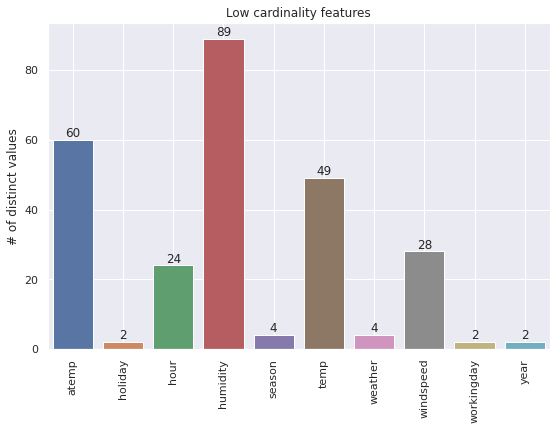

In [4]:
show_categoricals(data_extended, thr=100)

In [5]:
# ok, we will treat as categorical: holiday, hour, season, weather, windspeed, workingday, year

In [6]:
all_columns = data_extended.columns

# cols to be ignored
# atemp and temp are strongly correlated (0.98) we're taking only one
del_columns = ["datetime", "casual", "registered", "temp"]

TARGET = "count"
cat_cols = ["season", "holiday", "workingday", "weather", "windspeed", "hour", "year"]
num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))
features = sorted(cat_cols + num_cols)

print("All columns:", len(all_columns))
print("Ignored columns:", len(del_columns))
print("Target:", len([TARGET]))
print("Categorical columns:", len(cat_cols))
print("Numerical columns:", len(num_cols))
print("All the features", len(features))

All columns: 14
Ignored columns: 4
Target: 1
Categorical columns: 7
Numerical columns: 2
All the features 9


In [7]:
# drop ignored columns
data_used = data_extended.drop(del_columns, axis=1)

In [8]:
# let's code categorical
# windspeed need a special treatment
le_list = train_encoders(data_extended)

# coding
data_used = apply_encoders(data_used, le_list)

# define indexes for cat_cols
# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(features) if col in cat_cols]

train for coding: season 
train for coding: weather 
train for coding: year 

Coding: season 
Coding: weather 
Coding: year 


### ADSTuner session

In [9]:
#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {
    "n_estimators": CategoricalDistribution([1000, 2000, 3000, 4000, 5000]),
    "learning_rate": LogUniformDistribution(low=1e-4, high=1e-2),
    "max_depth": IntUniformDistribution(5, 10),
}

alg_reg = xgb.XGBRegressor()

# define the scorer function for ADSTuner, see def for rmsle before
scorer = make_scorer(rmsle, greater_is_better=False)

# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(
    alg_reg, cv=FOLDS, strategy=params, scoring=scorer, study_name=STUDY_NAME
)

x_train = data_used[features]
y_train = data_used[TARGET]

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

[I 2022-03-03 22:19:06,727] A new study created in RDB with name: Bike sharing11


### Analyze trials

In [109]:
# get the status to see if completed
print(f"The tuner status is: {tuner.get_status()}")

print(f"Remaining time is: {round(tuner.time_remaining, 1)} sec.")

The tuner status is: State.COMPLETED
Remaining time is: 0 sec.


In [110]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
    by=["value"], ascending=False
)

result_df.head(10)

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,user_attrs_mean_fit_time,user_attrs_mean_score_time,...,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_split5_test_score,user_attrs_split6_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
13,13,-0.438213,2022-03-03 22:42:11.746631,2022-03-03 22:47:40.796423,0 days 00:05:29.049792,0.000439,9,5000,46.794030,0.180564,...,-0.462332,-0.361393,-0.414863,-0.410762,-0.319528,-0.388038,0.262670,0.005604,0.118662,COMPLETE
18,18,-0.438659,2022-03-03 23:03:43.672108,2022-03-03 23:09:15.887868,0 days 00:05:32.215760,0.001044,9,5000,47.248484,0.180511,...,-0.426791,-0.357280,-0.438000,-0.397231,-0.334848,-0.369671,0.264212,0.003215,0.130364,COMPLETE
6,6,-0.445628,2022-03-03 22:27:34.567130,2022-03-03 22:29:13.494365,0 days 00:01:38.927235,0.001134,8,2000,14.043286,0.061862,...,-0.434924,-0.353468,-0.419828,-0.402834,-0.314416,-0.444075,0.053271,0.000386,0.131406,COMPLETE
11,11,-0.446357,2022-03-03 22:37:53.577749,2022-03-03 22:41:07.218487,0 days 00:03:13.640738,0.000650,9,3000,27.523481,0.109448,...,-0.483275,-0.372962,-0.413082,-0.422411,-0.333010,-0.405706,0.135997,0.004003,0.109730,COMPLETE
12,12,-0.453616,2022-03-03 22:41:07.232504,2022-03-03 22:42:11.732483,0 days 00:01:04.499979,0.001801,9,1000,9.147669,0.037494,...,-0.501346,-0.382625,-0.413902,-0.432039,-0.346585,-0.421429,0.057141,0.000277,0.101367,COMPLETE
14,14,-0.459691,2022-03-03 22:47:40.810656,2022-03-03 22:53:06.819030,0 days 00:05:26.008374,0.000342,9,5000,46.361219,0.179896,...,-0.515166,-0.390879,-0.414624,-0.440085,-0.357802,-0.434273,0.239442,0.005556,0.095177,COMPLETE
15,15,-0.471754,2022-03-03 22:53:06.833169,2022-03-03 22:57:00.294724,0 days 00:03:53.461555,0.001809,8,5000,33.175006,0.145589,...,-0.449994,-0.376193,-0.446309,-0.408655,-0.392863,-0.438188,0.224114,0.001002,0.132511,COMPLETE
9,9,-0.472359,2022-03-03 22:33:37.711238,2022-03-03 22:35:30.223872,0 days 00:01:52.512634,0.000604,7,3000,15.967208,0.074516,...,-0.459564,-0.379252,-0.440357,-0.427826,-0.363773,-0.467538,0.089445,0.000453,0.126026,COMPLETE
1,1,-0.473234,2022-03-03 22:19:35.944431,2022-03-03 22:23:28.068429,0 days 00:03:52.123998,0.001987,8,5000,32.987594,0.144423,...,-0.454054,-0.377158,-0.459116,-0.411327,-0.376884,-0.462370,0.334953,0.001249,0.126565,COMPLETE
19,19,-0.474426,2022-03-03 23:09:15.901949,2022-03-03 23:15:32.355577,0 days 00:06:16.453628,0.002722,10,5000,53.547051,0.201562,...,-0.522252,-0.371655,-0.456018,-0.443826,-0.359344,-0.402886,1.453483,0.002799,0.129239,COMPLETE


In [111]:
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has completed 21 trials

The best trial is the #: 13
Parameters for the best trial are: {'learning_rate': 0.0004394857413078558, 'max_depth': 9, 'n_estimators': 5000}
The metric used to optimize is: rmsle, greater_is_better=False
The best score is: -0.4382


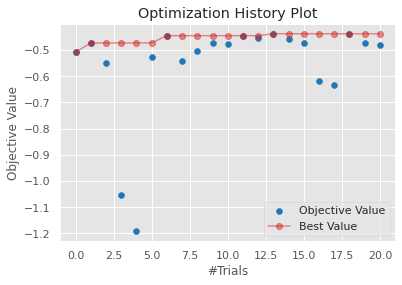

In [112]:
tuner.plot_best_scores()

### train the model with the best params

In [113]:
%%time

model = xgb.XGBRegressor(**tuner.best_params)

model.fit(x_train, y_train)

CPU times: user 2min 42s, sys: 1.46 s, total: 2min 44s
Wall time: 53.2 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0004394857413078558,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Prediction and submission to Kaggle

In [114]:
test_orig = pd.read_csv(FILE_TEST)

In [115]:
# add engineered features
# feature engineering

test_orig = add_features(test_orig)

# coding
test_orig = apply_encoders(test_orig, le_list)

# data on which do scoring
x_test = test_orig[features]

Coding: season 
Coding: weather 
Coding: year 


In [116]:
# scoring

score_test = model.predict(x_test)

### prepare submission

In [117]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [118]:
# remove decimals
df_sub["count"] = np.round(score_test, 0)

# remove eventual negative
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [119]:
FILE_SUB_PREFIX = "sub-demo-003"
FILE_SUB = FILE_SUB_PREFIX + ".csv"

df_sub.to_csv(FILE_SUB, index=False)

### Submission

In [120]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub demo 003, adstuner"

100%|████████████████████████████████████████| 162k/162k [00:03<00:00, 47.4kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
print(lgb.__version__)